# Разведочный анализ данных

## Описание данных:


| Поле                     | Описание                                                                              |
| :------------------------| :-------------------------------------------------------------------------------------|
| survival                 | 1 - пассажир выжил; 0 - пассажир погиб                                                |
| pclass                   | Класс билета: 1 - высокий; 2 - средний; 3 - низкий                                    |
| sex                      | Пол пассажира                                                                         |
| age                      | возраст, лет                                                                          |
| sibsp                    | наличие родственников (жены, мужа, брата, сестры, двоюродных братьев, сестер)         |
| parch                    | наличие родственников (матери, отца, сына, дочери, приемных детей)                    |
| ticket                   | номер билета                                                                          |
| fare                     | стоимость билета                                                                      |
| cabin                    | номер каюты                                                                           |
| embarked                 | порт посадки: C = Cherbourg, Q = Queenstown, S = Southampton                          |

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import re
from scipy.stats import chi2_contingency

import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale = 1.2)

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_column', None)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Загрузим данные, посмотрим на их размерность и отобразим первые 5 строк
df = pd.read_csv('tabular_playground.csv')
print(f'Размерность данных {df.shape}')
df.head()

Размерность данных (100000, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [3]:
# Приведем названия колонок к нижнему регистру
col_names = [(re.sub(r'([A-Z])', r' \1', i)).strip().replace(' ', '_').lower() for i in df.columns]
df.rename(columns={i: j for i, j in zip(df.columns, col_names)}, inplace=True)
df.head()

,passenger_id,survived,pclass,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [4]:
# Посмотрим на типы данных в датафрейме
df.dtypes

passenger_id      int64
survived          int64
pclass            int64
name             object
sex              object
age             float64
sib_sp            int64
parch             int64
ticket           object
fare            float64
cabin            object
embarked         object
dtype: object

In [5]:
# Посмотрим есть ли пропущенные значения в данных
missing = df.isna().sum()
missing[missing > 0]

age          3292
ticket       4623
fare          134
cabin       67866
embarked      250
dtype: int64

In [6]:
# Посмотрим есть ли дубликаты строк в датафрейме
df.duplicated().sum()

0

In [7]:
# Посмотрим на описательную статистику
df.drop(columns=['passenger_id']).describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
survived,100000.0,0.428,0.495,0.00,0.00,0.00,1.0,1.00
pclass,100000.0,2.107,0.838,1.00,1.00,2.00,3.0,3.00
age,96708.0,38.355,18.314,0.08,25.00,39.00,53.0,87.00
sib_sp,100000.0,0.398,0.863,0.00,0.00,0.00,1.0,8.00
parch,100000.0,0.455,0.950,0.00,0.00,0.00,1.0,9.00
fare,99866.0,43.929,69.589,0.68,10.04,24.46,33.5,744.66


In [8]:
# Посмотрим на описательную статистику по категориальным переменным
df.describe(include=['O']).T

,count,unique,top,freq
name,100000,92144,"Johnson, John",31
sex,100000,2,male,56114
ticket,95377,75331,A/5,602
cabin,32134,26992,C19828,6
embarked,99750,3,S,72139


В исследуемой совокупности доля пассажиров мужского пола составляет 56%.

### Посмотрим на коэффициент выживаемости в зависимости от пола.

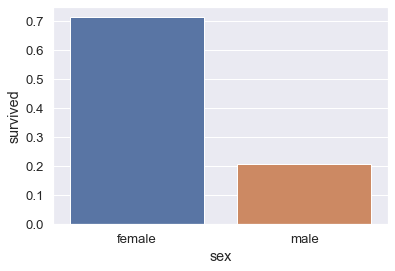

In [9]:
surv = df.groupby('sex', as_index=False)[['survived']].mean().round(3)
sns.barplot(x='sex', y='survived', data=surv);

Из полученных значений видно, что практически три четверти находившихся на борту женщин выжило, в то время как из мужчин выжил
только каждый пятый.

### Посмотрим на количество выживших в зависимости от класса билета.

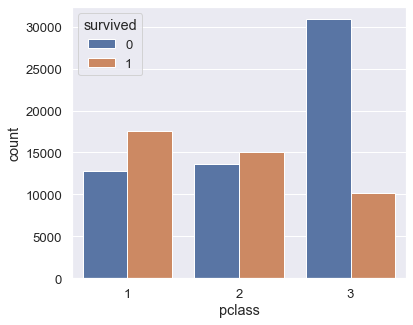

In [10]:
surv_class = df.groupby(['pclass', 'survived'], as_index=False) \
    .agg(count=('sex', 'count'))

plt.figure(figsize=(6, 5))
sns.barplot(x='pclass', y='count', hue='survived', data=surv_class);

Из полученных значений видно выживаемость для пассажиров 1-го класса значительно выше чем для пассажиров 3-го класса.

### Посмотрим на распределение выживших по полу и классу билета.

In [11]:
df.pivot_table(index='sex', columns='pclass', values='survived', margins=True) \
    .style \
    .background_gradient(cmap='Accent_r')

pclass,1,2,3,All
sex,,,,
female,0.768279,0.769024,0.568416,0.711525
male,0.366735,0.246641,0.106189,0.205795
All,0.579779,0.525018,0.247305,0.427740


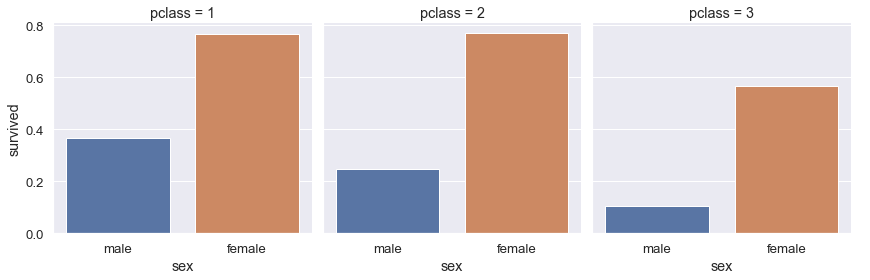

In [12]:
class_surv = sns.FacetGrid(df, col='pclass', height=4, aspect=1)
class_surv.map(sns.barplot, 'sex', 'survived', palette='deep', ci=None)
class_surv.add_legend();

Из полученных значений видно шансы выжить для женщин купивших билет 3 класса значительно ниже чем для женщин купивших билет 1 или 2 класса. При этом шансы выжить для мужчин снижаются от более высокого класса к низкому классу.<br>
Из всех пассажиров выжило только 42.8%

### Посмотрим на распределение возраста пассажиров.

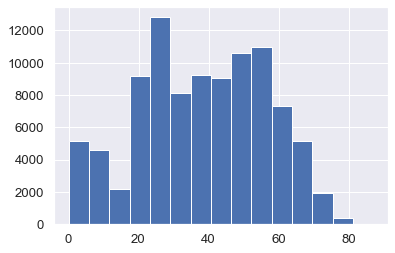

In [13]:
df.age.hist(bins=15);

Возраст большинства пассажиров от 20 до 60 лет.<br>

**Посчитаем асимметрию и эксцесс распределения пассажиров по возрасту.**

In [14]:
print(f'Skew of age: {df.age.skew():.3}')
print(f'Kurtosis of age: {df.age.kurtosis():.3}')

Skew of age: -0.154
Kurtosis of age: -0.802


- Ассиметрия незначительна: [$0.25 > |A|$](http://mathprofi.ru/asimmetriya_i_excess.html)
- Распределение является более низким и пологим: [$E_{k} < 0$](http://mathprofi.ru/asimmetriya_i_excess.html)

### Посмотрим как взаимосвязаны возраст и выживаемость.

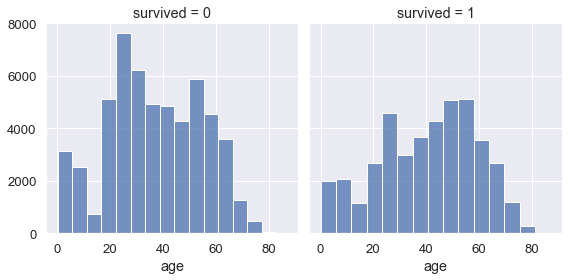

In [15]:
age_surv = sns.FacetGrid(df, col='survived', height=4, aspect=1)
age_surv.map(sns.histplot, 'age', bins=15);

- Большое количество пассажиров в возрасте от 0 до 15 не выжило;
- Среди выживших есть люди в возрасте от 60 до 80 лет.

### Посмотрим на распределение возраста пассажиров в зависимости от порта посадки.

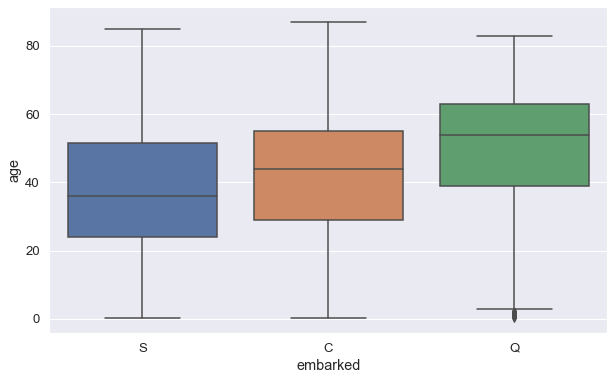

In [16]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='embarked', y='age');

In [17]:
# Посмотрим на распределение возраста в зависимости от порта посадки с помощью описательной статистики
df.groupby('embarked').age.describe(percentiles=[0, 1/6, 1/3, .5, 2/3, 5/6, 1]).round(2)

,count,mean,std,min,0%,16.7%,33.3%,50%,66.7%,83.3%,100%,max
embarked,,,,,,,,,,,,
C,21456.0,41.85,17.66,0.08,0.08,24.0,35.0,44.0,52.0,59.0,87.0,87.0
Q,5237.0,50.08,16.99,0.25,0.25,30.0,45.0,54.0,61.0,66.0,83.0,83.0
S,69767.0,36.40,18.12,0.08,0.08,20.0,27.0,36.0,46.0,56.0,85.0,85.0


Пассажиры с портом посадки `S` более молодые.

### Посмотрим как взаимосвязаны возраст, порт посадки и выживаемость.

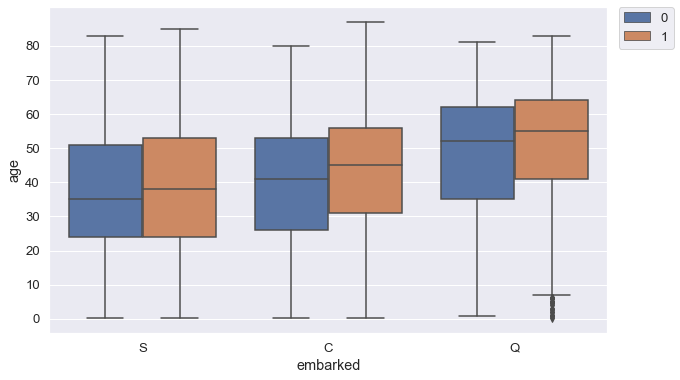

In [18]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='embarked', y='age', hue='survived')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)
ax.set_yticks(np.arange(0, 90, 10));

### Посмотрим как взаимосвязаны возраст, класс билета и выживаемость.

In [19]:
df['age_bins'] = pd.cut(df['age'], 
                        bins=[0, 15, 30, 45, 60, 75, 90], 
                        labels=['0-15', '15-30', '30-45', '45-60', '60-75', 'above 75'])

In [20]:
df.pivot_table(index='pclass', columns='age_bins', values='survived') \
    .style \
    .background_gradient(cmap='Accent_r')

age_bins,0-15,15-30,30-45,45-60,60-75,above 75
pclass,,,,,,
1,0.461774,0.508768,0.579735,0.600501,0.627374,0.565217
2,0.591623,0.467352,0.469025,0.532223,0.614612,0.839506
3,0.350364,0.220827,0.190116,0.237093,0.319918,0.556604


- Для пассажиров в возрасте от 15 до 60 лет с билетом 1-го класса шансов выжить больше;
- Для пассажиров в возрасте от 0 до 15 лет с билетом 2-го класса шансов выжить больше;
- Большая часть пассажиров всех возрастов с билетом 3-го класса не выжили.

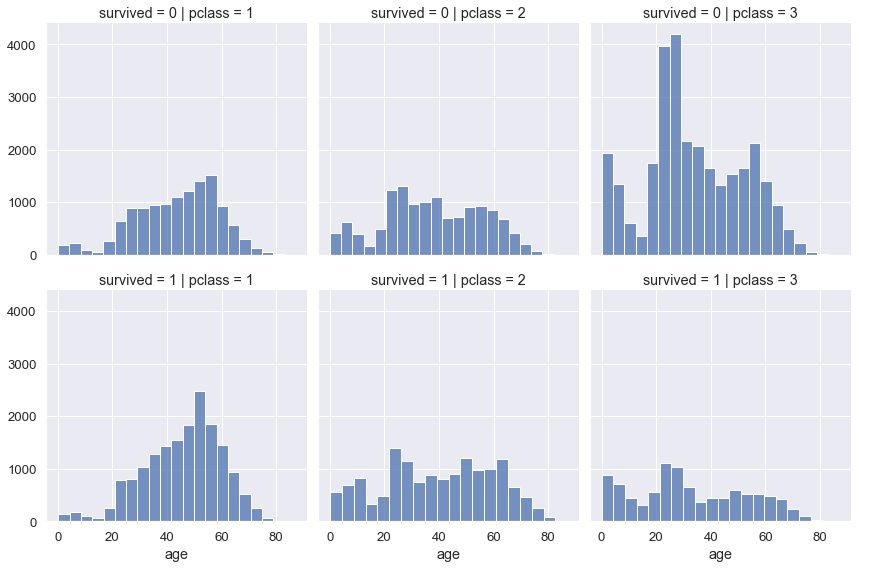

In [21]:
# Отобразим взаимосвязь возраста, класс билета и выживаемость с помощью гистограмм
class_age = sns.FacetGrid(df, col='pclass', row='survived', height=4, aspect=1)
class_age.map(sns.histplot, 'age', bins=20)
class_age.add_legend();

### Посмотрим на распределение выживших пассажиров в зависимости от порта посадки.

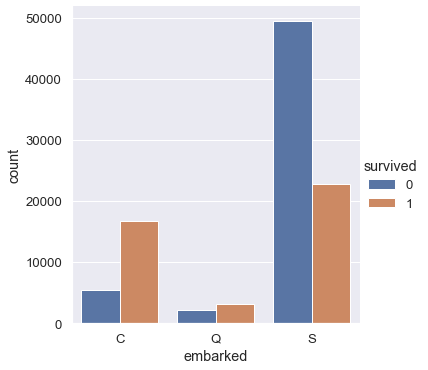

In [22]:
emb = df.groupby(['embarked', 'survived'], as_index=False) \
    .agg(count=('sex', 'count'))

sns.catplot(x='embarked', y='count', kind='bar', hue='survived', data=emb);

Пассажиров с портом посадки `Q` выживших наименьшее количество.

### Посмотрим как взаимосвязаны порт посадки, класс билета и выживаемость.

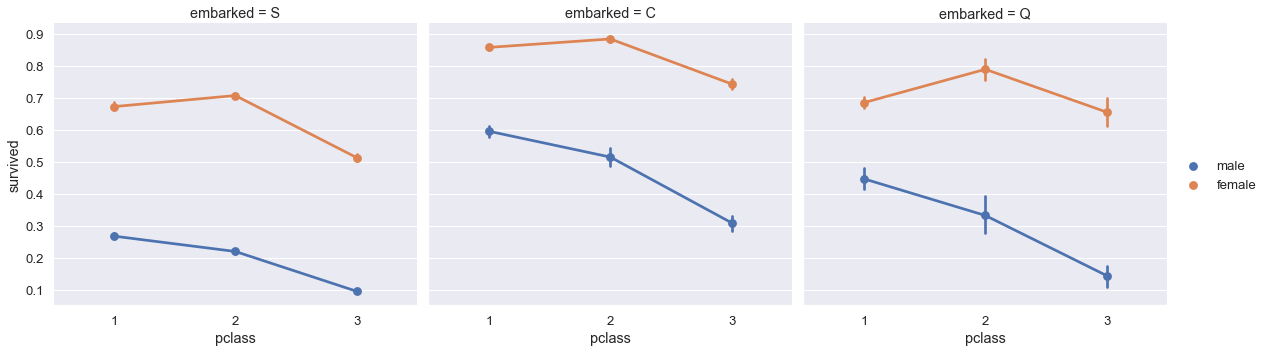

In [23]:
emb_surv = sns.FacetGrid(df, col='embarked', height=5, aspect=1.1)
emb_surv.map(sns.pointplot, 'pclass', 'survived', 'sex', palette='deep')
emb_surv.add_legend();

- В независимости от порта посадки, шансы выжить для женщин выше чем для мужчин;
- Шансы выжить для женщин с 2-м классом билета, которые сели на борт в порту `Q` выше чем для женщин с билетом 1-го класса этого же порта посадки;
- В независимости от порта посадки, шансы выжить для мужчин с билетом 1-го класса выше.

### Посмотрим как взаимосвязаны порт посадки, стоимость билета и выживаемость.

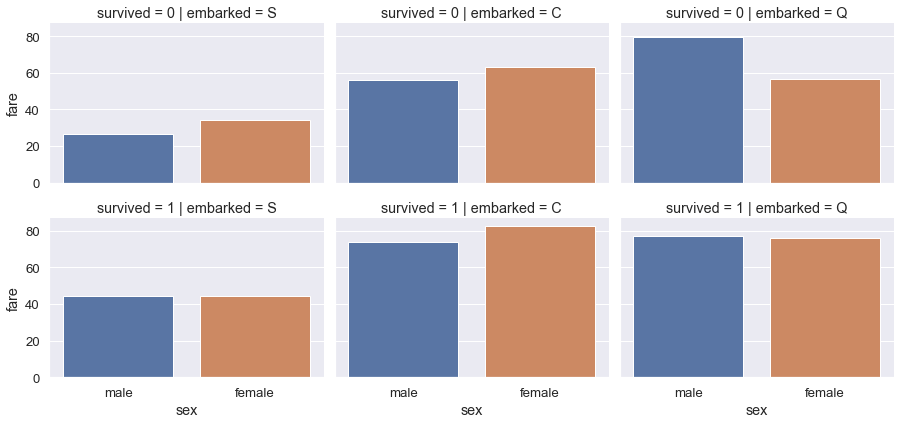

In [24]:
fare_emb = sns.FacetGrid(df, row='survived', col='embarked', height=3, aspect=1.4)
fare_emb.map(sns.barplot, 'sex', 'fare', palette='deep', ci=None)
fare_emb.add_legend();

Для женщин купивших билет по более высокой стоимости шансы выжить выше.

### Посмотрим как взаимосвязаны наличие родственников и выживаемость.

In [25]:
df.pivot_table(index='sex', columns='sib_sp', values='survived', margins=True) \
    .style \
    .background_gradient(cmap='Accent_r')

sib_sp,0,1,2,3,4,5,8,All
sex,,,,,,,,
female,0.744308,0.627771,0.700228,0.558140,0.598881,0.323529,0.606061,0.711525
male,0.191853,0.256703,0.231362,0.242054,0.186709,0.142857,0.207317,0.205795
All,0.426843,0.433748,0.453956,0.400000,0.375856,0.189394,0.385135,0.427740


In [26]:
df.pivot_table(index='sex', columns='parch', values='survived', margins=True) \
    .style \
    .background_gradient(cmap='Accent_r')

parch,0,1,2,3,4,5,6,9,All
sex,,,,,,,,,
female,0.732608,0.739582,0.575270,0.635727,0.455556,0.704641,0.400000,0.602649,0.711525
male,0.189318,0.341159,0.215785,0.293689,0.169173,0.234043,0.125000,0.221239,0.205795
All,0.405208,0.592028,0.384745,0.492370,0.284753,0.570997,0.205882,0.439394,0.427740


Для мужчины, у которых был один ребенок шансы выжить были выше чем для одиноких.<br>

Проверим, есть ли статистически значимые различия для мужчин с разлчным количеством детей. Поскольку у нас категориальные переменные, для проверки гипотезы применим хи-квадрат.

In [27]:
# Сгруппируем данные по мужчинам
male_table = pd.crosstab(df[df['sex'] == 'male'].survived, df.parch)
male_table

parch,0,1,2,3,4,5,6,9
survived,,,,,,,,
0,35927,3171,4670,291,221,72,126,88
1,8390,1642,1285,121,45,22,18,25


In [28]:
# Применим хи-квадрат
chi_ = chi2_contingency(male_table)
print(f'p-value: {chi_[1]}')

p-value: 5.2788780160077133e-135


$p$-значение $< 0.05$, таким образом между группами разных пассажиров есть статистически значимые различия.

#### Объединим данные по столбцам `sib_sp` и `parch` в одну переменную, создадим дополнительных столбец `is_alone` и посмотрим на выживаемости пассажиров в зависимости от того были ли у него родственники.

In [29]:
df['family_size'] = df.sib_sp + df.parch
df['is_alone'] = df.family_size.apply(lambda x: 'not_alone' if x > 0 else 'alone')
df.pivot_table(index='sex', columns='is_alone', values='survived', margins=True) \
    .style \
    .background_gradient(cmap='Accent_r')

is_alone,alone,not_alone,All
sex,,,
female,0.743479,0.671154,0.711525
male,0.182032,0.253119,0.205795
All,0.404394,0.465594,0.427740


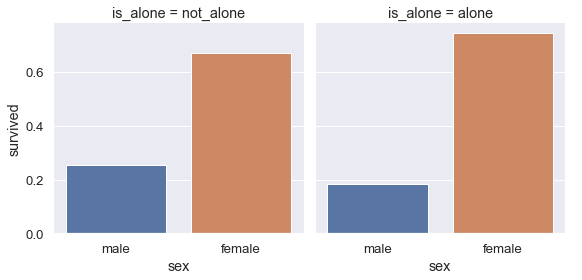

In [30]:
alone = sns.FacetGrid(df, col='is_alone', height=4, aspect=1)
alone.map(sns.barplot, 'sex', 'survived', palette='deep', ci=None)
alone.add_legend();

- Шансы выжить для женщин, путешествующих самостоятельно незначительно выше чем для женщин имеющих родственников на борту;
- Шансы выжить для мужчин, путешествующих с родственниками выше чем для мужчин путешествующих самостоятельно.

### Посмотрим на распределение стоимости билетов

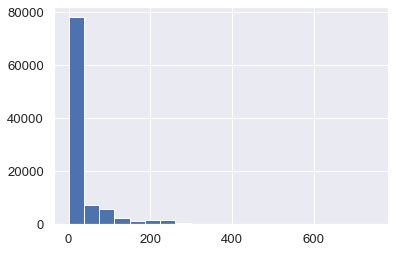

In [31]:
df.fare.hist(bins=20);

Большее количество проданных билетов не превышает стоимости 200 ден. ед.<br>

**Посчитаем асимметрию и эксцесс распределения стоимости билетов.**

In [32]:
print(f'Skew of fare: {df.fare.skew():.3}')
print(f'Kurtosis of fare: {df.fare.kurtosis():.3}')

Skew of fare: 3.92
Kurtosis of fare: 19.6


- Ассиметрия существенна: [$0.5 < |A|$](http://mathprofi.ru/asimmetriya_i_excess.html)
- Распределение является более высоким: [$E_{k} > 0$](http://mathprofi.ru/asimmetriya_i_excess.html)

### Посмотрим как распределена стоимость билетов в зависимости от класса.

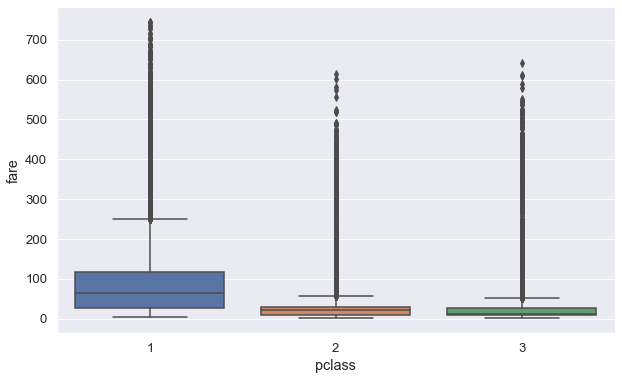

In [33]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='pclass', y='fare')
ax.set_yticks(np.arange(0, 750, 100));

Из boxplot видно, что переменная `fare` в разрезе каждого класса содержит большое количество наблюдений, которые можно считать выбросами.

In [34]:
# Посмотрим на распределение с помощью описательной статистики
df.groupby('pclass').fare.describe(percentiles=[0, 1/6, 1/3, .5, 2/3, 5/6, 1]).round(2)

,count,mean,std,min,0%,16.7%,33.3%,50%,66.7%,83.3%,100%,max
pclass,,,,,,,,,,,,
1,30275.0,92.65,99.82,3.38,3.38,25.20,30.31,63.58,83.95,180.01,744.66,744.66
2,28637.0,25.76,34.85,1.72,1.72,8.93,11.60,22.72,27.34,31.40,613.43,613.43
3,40954.0,20.62,32.62,0.68,0.68,7.70,9.34,10.96,18.78,29.37,640.79,640.79


Более 80% купленных билетов не превышают стоимости 180 ден.единиц. При этом встречаются наблюдения со стоимостью билета для 2-го и 3-го класса более 600 ден. ед.<br>
Посмотрим сколько у нас наблюдений для каждого класса со стоимостью билета выше 180 ден.ед.

In [35]:
first = df.query('pclass == 1 & fare > 180').shape[0]
second = df.query('pclass == 2 & fare > 180').shape[0]
third = df.query('pclass == 3 & fare > 180').shape[0]

print(f'Количество билетов 1-го класса стоимостью выше 180: {first} \
      \nКоличество билетов 2-го класса стоимостью выше 180: {second} \
      \nКоличество билетов 2-го класса стоимостью выше 180: {third}')

Количество билетов 1-го класса стоимостью выше 180: 5046       
Количество билетов 2-го класса стоимостью выше 180: 300       
Количество билетов 2-го класса стоимостью выше 180: 265


Можно предположить что исследуемые выбросы не являются ошибками в данных.

### Посмотрим как распределена стоимость билетов в зависимости от возраста пассажиров.

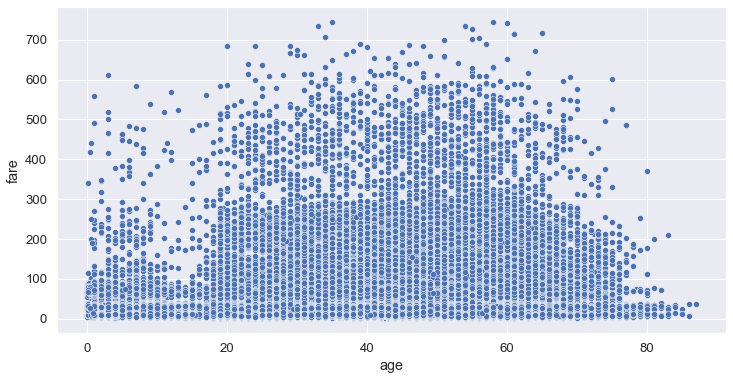

In [36]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='age', y='fare');

### Посмотрим как распределена стоимость билетов в зависимости от возраста и выживаемости пассажиров.

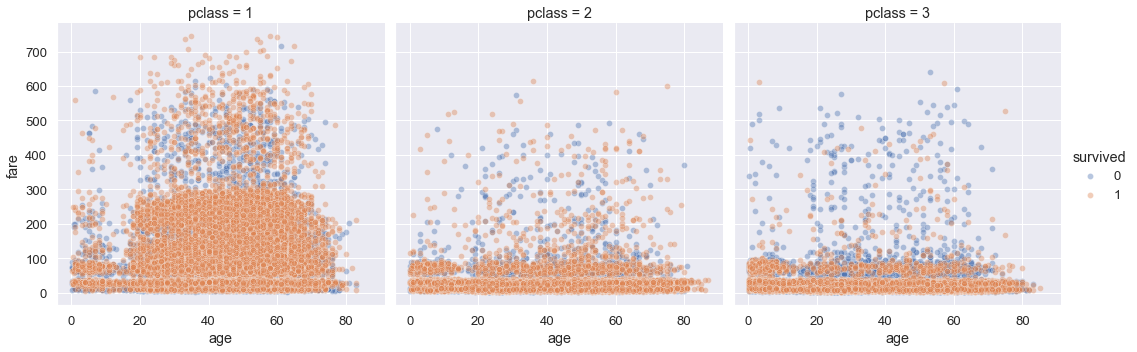

In [37]:
age_fare = sns.FacetGrid(df, col='pclass', hue='survived', height=5)
age_fare.map(sns.scatterplot, 'age', 'fare', alpha=0.4)
age_fare.add_legend();

Большая часть пассажиров с билетом 3-го класса и стоимостью свыше 200 ден. ед. не выжили.

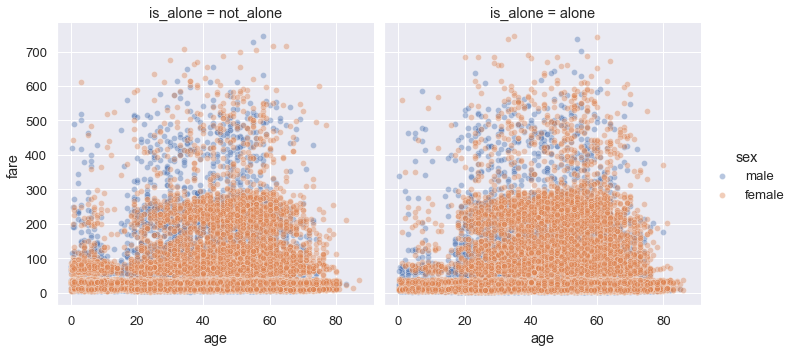

In [38]:
alone_fare = sns.FacetGrid(df, col='is_alone', hue='sex', height=5)
alone_fare.map(sns.scatterplot, 'age', 'fare', alpha=0.4)
alone_fare.add_legend();

### Посмотрим на матрицу корреляции Пирсона.

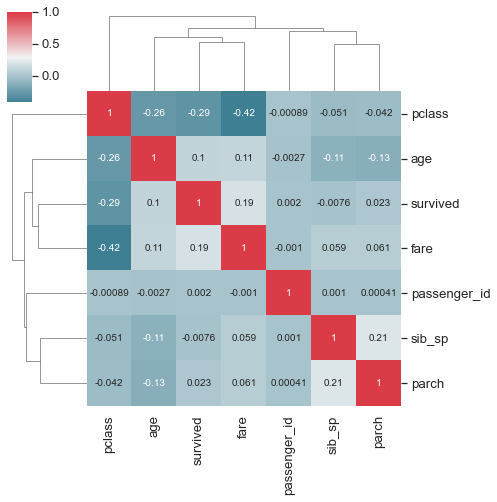

In [39]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax=sns.clustermap(df.drop(columns=['family_size', 'is_alone']).corr(), cmap=cmap, figsize=(7, 7), annot=True)

Между исследуемыми признаками нет сильной линейной корреляции.

## Выводы:

- В исследуемой совокупности доля пассажиров мужского пола составляет 56%.
- Практически три четверти находившихся на борту женщин выжило, в то время как из мужчин выжил только каждый пятый.
- Из всех пассажиров выжило только 42,8%.
- Выживаемость для пассажиров 1-го класса значительно выше чем для пассажиров 3-го класса.
- Большое количество пассажиров в возрасте от 0 до 15 не выжило.
- Для пассажиров в возрасте от 15 до 60 лет с билетом 1-го класса шансов выжить больше.
- Для пассажиров в возрасте от 0 до 15 лет с билетом 2-го класса шансов выжить больше.
- Большая часть пассажиров всех возрастов с билетом 3-го класса не выжили.
- В независимости от порта посадки, шансы выжить для женщин выше чем для мужчин.
- В независимости от порта посадки, шансы выжить для мужчин с билетом 1-го класса выше.
- Пассажиры с портом посадки `S` более молодые.
- Пассажиров с портом посадки Q выживших наименьшее количество.
- Шансы выжить для женщин с 2-м классом билета, которые сели на борт в порту Q выше чем для женщин с билетом 1-го класса этого же порта посадки.
- Для женщин купивших билет по более высокой стоимости шансы выжить выше.
- Шансы выжить для женщин, путешествующих самостоятельно незначительно выше чем для женщин имеющих родственников на борту.
- Шансы выжить для мужчин, путешествующих с родственниками выше чем для мужчин путешествующих самостоятельно.
- Более 80% купленных билетов не превышают стоимости 180 ден. единиц.